In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display

In [9]:
# source of Furfuri (song by Kuma Sagar):
# https://www.youtube.com/watch?v=FLbE0IkHLkg

# source of A Mai Re - 'Hawa Ko Lahar' (song by Kuma Sagar):
# https://www.youtube.com/watch?v=gebozQyu-pY


In [45]:
""" A class built with the librosa library to identify the musical key and emotion of an MP3 file,
offering configurable parameters for enhanced analysis.
The key arguments include the waveform (an MP3 file loaded through librosa,
preferably with percussive elements removed),
the sr (sampling rate obtained during file loading),
and tstart and tend (optional parameters defining the time range in seconds for analysis,
defaulting to the file's full duration if unspecified).
"""
class Tonal_Fragment(object):
    def __init__(self, waveform, sr, tstart=None, tend=None):
        self.waveform = waveform
        self.sr = sr
        self.tstart = tstart
        self.tend = tend

        if self.tstart is not None:
            self.tstart = librosa.time_to_samples(self.tstart, sr=self.sr)
        if self.tend is not None:
            self.tend = librosa.time_to_samples(self.tend, sr=self.sr)
        self.y_segment = self.waveform[self.tstart:self.tend]
        self.chromograph = librosa.feature.chroma_cqt(y=self.y_segment, sr=self.sr, bins_per_octave=24)

        # chroma_vals represents the quantity of each pitch class present
        # within the specified time interval.
        self.chroma_vals = []
        for i in range(12):
            self.chroma_vals.append(np.sum(self.chromograph[i]))
        pitches = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
        # A dictionary mapping pitch names to their corresponding intensity values within the song.
        self.keyfreqs = {pitches[i]: self.chroma_vals[i] for i in range(12)}

        keys = [pitches[i] + ' major' for i in range(12)] + [pitches[i] + ' minor' for i in range(12)]
        """
        Using the Krumhansl-Schmuckler key-finding algorithm, the chroma data is analyzed and
        compared against established key profiles for major and minor scales,
        helping to identify the most likely key of the music.
        """
        maj_profile = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
        min_profile = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]
        """
        The algorithm computes the correlations between the distribution of each pitch class
        in the time interval and the key profiles for all 12 pitches, then generates
        a dictionary mapping each musical key (major/minor) to its corresponding correlation value.
        """
        self.min_key_corrs = []
        self.maj_key_corrs = []
        for i in range(12):
            key_test = [self.keyfreqs.get(pitches[(i + m)%12]) for m in range(12)]
            # Correlation coefficients represent the strength of the relationship between the pitch class
            self.maj_key_corrs.append(round(np.corrcoef(maj_profile, key_test)[1,0], 3))
            self.min_key_corrs.append(round(np.corrcoef(min_profile, key_test)[1,0], 3))

        # names of all major and minor keys
        self.key_dict = {**{keys[i]: self.maj_key_corrs[i] for i in range(12)},
                         **{keys[i+12]: self.min_key_corrs[i] for i in range(12)}}

        # This attribute denotes the key identified by the algorithm.
        self.key = max(self.key_dict, key=self.key_dict.get)
        self.bestcorr = max(self.key_dict.values())

        # This attribute represents the second-highest key identified by the algorithm,
        # selected when its correlation is nearly as strong as the primary key.
        self.altkey = None
        self.altbestcorr = None

        for key, corr in self.key_dict.items():
            if corr > self.bestcorr*0.9 and corr != self.bestcorr:
                self.altkey = key
                self.altbestcorr = corr

    # Displays the relative prominence of each pitch class in the analysis.
    def print_chroma(self):
        self.chroma_max = max(self.chroma_vals)
        for key, chrom in self.keyfreqs.items():
            print(key, '\t', f'{chrom/self.chroma_max:5.3f}')

    # Generates the correlation coefficients linked to each major and minor key.
    def corr_table(self):
        for key, corr in self.key_dict.items():
            print(key, '\t', f'{corr:6.3f}')

    # printout of the key determined by the algorithm; if another key is close, that key is mentioned
    def print_key(self):
        print("likely key: ", max(self.key_dict, key=self.key_dict.get), ", correlation: ", self.bestcorr, sep='')
        if self.altkey is not None:
                print("also possible: ", self.altkey, ", correlation: ", self.altbestcorr, sep='')

    def print_chroma_e(self):
        self.chroma_max = max(self.chroma_vals)
        e=""
        for key, chrom in self.keyfreqs.items():
            if key==max(self.key_dict, key=self.key_dict.get) : e=="emotion"
            print(key, '\t', f'{chrom/self.chroma_max:5.3f}', '\t', e)

    def corr_table_e(self, kr):
        for key, corr in self.key_dict.items():
            e=""
            if key==max(self.key_dict, key=self.key_dict.get) : e=kr
            x=max(self.key_dict, key=self.key_dict.get)
            print(key, '\t', f'{corr:6.3f}', '\t', e)

    # Display the key identified by the algorithm, and if another key is nearby, include that key as well.
    def chromagram(self, title=None):
        C = librosa.feature.chroma_cqt(y=self.waveform, sr=sr, bins_per_octave=24)
        plt.figure(figsize=(12,4))
        librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
        if title is None:
            plt.title('Chromagram')
        else:
            plt.title(title)
        plt.colorbar()
        plt.tight_layout()
        plt.show()

    # Displays the corresponding emotion based on the key of the music.
    def key_return(self):
        k= max(self.key_dict, key=self.key_dict.get)
        c=k
        if self.altkey is not None:
            lk=self.altkey
            c=k+"(also likely "+lk+")"
        # px={"c maj": "ram", "d-h, jj#   dd": "hari fla"}

        thiss ={"C major": "Innocently Happy", "C minor": "Innocently Sad, Love-Sick", "C# minor": "Despair, Wailing, Weeping", "C# major": "Grief, Depressive", "D major": "Triumphant, Victorious War-Cries", "D minor": "Serious, Pious, Ruminating", "D# minor": "Deep Distress, Existential Angst", "D# major": "Cruel, Hard, Yet Full of Devotion", "E major": "Quarrelsome, Boisterous, Incomplete Pleasure", "E minor": "Effeminate, Amorous, Restless", "F major": "Furious, Quick-Tempered, Passing Regret", "F minor": "Obscure, Plaintive, Funereal", "F# major": "Conquering Difficulties, Sighs of Relief", "F# minor": "Gloomy, Passionate Resentment", "G major": "Serious, Magnificent, Fantasy", "G minor": "Discontent, Uneasiness", "G# major": "Death, Eternity, Judgement", "G# minor": "Grumbling, Moaning, Wailing", "A major": "Joyful, Pastoral, Declaration of Love", "A minor": "Tender, Plaintive, Pious", "A# major": "Joyful, Quaint, Cheerful", "A# minor": "Terrible, the Night, Mocking", "B major": "Harsh, Strong, Wild, Rage", "B minor": "Solitary, Melancholic, Patience"}
        x="Emotion: " +thiss[k]
        return x

In [37]:
# This audio may take a while to load due to its very high sampling rate
audio_path = '/content/drive/MyDrive/project25/furfuri-kuma-sagar.mp3'
ipd.Audio(audio_path)

In [38]:
# The load function returns a tuple containing an audio object y and its sampling rate sr.
y, sr = librosa.load(audio_path)
# This function separates the harmonic component
# from the percussive part of the sound file, enabling more precise harmonic analysis.
y_harmonic, y_percussive = librosa.effects.hpss(y)

In [39]:
"""
 This block creates an instance of the Tonal_Fragment class using the first 22 seconds of
 the harmonic part of Une Barque. The three methods invoked will display
 the song's determined key, the correlation coefficients for all keys, and a chromogram that
 visualizes the intensity of frequencies linked to each of the 12 pitch classes over time.
"""
furfuri_asharp_min = Tonal_Fragment(y_harmonic, sr, tend=22)
furfuri_asharp_min.print_chroma()

C 	 0.127
C# 	 0.330
D 	 0.211
D# 	 0.485
E 	 0.236
F 	 0.672
F# 	 0.312
G 	 0.227
G# 	 0.515
A 	 0.311
A# 	 1.000
B 	 0.363


likely key: A# minor, correlation: 0.739
C major 	 -0.519
C# major 	  0.339
D major 	 -0.485
D# major 	  0.503
E major 	 -0.211
F major 	  0.185
F# major 	  0.279
G major 	 -0.621
G# major 	  0.273
A major 	 -0.401
A# major 	  0.665
B major 	 -0.007
C minor 	 -0.153
C# minor 	 -0.224
D minor 	  0.044
D# minor 	  0.465
E minor 	 -0.564
F minor 	  0.314
F# minor 	 -0.268
G minor 	  0.175
G# minor 	  0.202
A minor 	 -0.403
A# minor 	  0.739
B minor 	 -0.326


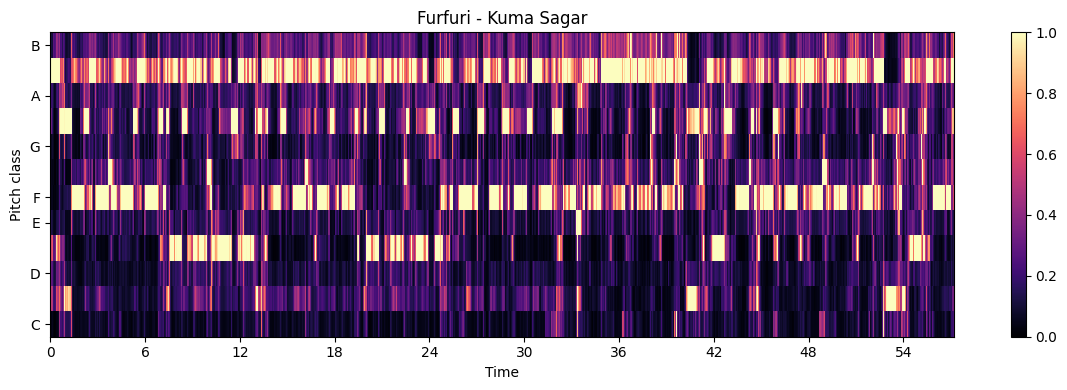

In [41]:
furfuri_asharp_min.print_key()
furfuri_asharp_min.corr_table()
furfuri_asharp_min.chromagram("Furfuri - Kuma Sagar")

In [49]:
"""
This algorithm offers high accuracy in its results, as demonstrated in the
next section of the 'Furfuri' clip,
t=22 sec to t=33 sec, which is also in A# minor:
"""
furfuri_g_min = Tonal_Fragment(y_harmonic, sr, tstart=22, tend=33)
furfuri_g_min.print_key()
print(furfuri_g_min.key_return())
furfuri_asharp_min.corr_table_e(furfuri_g_min.key_return)
# furfuri_g_min.corr_table()

likely key: A# minor, correlation: 0.7
Emotion: Terrible, the Night, Mocking
C major 	 -0.519 	 
C# major 	  0.339 	 
D major 	 -0.485 	 
D# major 	  0.503 	 
E major 	 -0.211 	 
F major 	  0.185 	 
F# major 	  0.279 	 
G major 	 -0.621 	 
G# major 	  0.273 	 
A major 	 -0.401 	 
A# major 	  0.665 	 
B major 	 -0.007 	 
C minor 	 -0.153 	 
C# minor 	 -0.224 	 
D minor 	  0.044 	 
D# minor 	  0.465 	 
E minor 	 -0.564 	 
F minor 	  0.314 	 
F# minor 	 -0.268 	 
G minor 	  0.175 	 
G# minor 	  0.202 	 
A minor 	 -0.403 	 
A# minor 	  0.739 	 Emotion: Terrible, the Night, Mocking
B minor 	 -0.326 	 


In [1]:
# The following block displays the predicted key for every 3-second section of the piece.
bin_size = 3
for i in range(24):
    fragment = Tonal_Fragment(y_harmonic, sr, tstart = bin_size*i, tend=bin_size*(i+1))
    print(bin_size*i,"sec:",fragment.key)
    if fragment.altkey is not None:
        print("\t or:", fragment.altkey)

NameError: name 'Tonal_Fragment' is not defined

likely key: A# major, correlation: 0.499
also possible: G minor, correlation: 0.464
Emotion: Joyful, Quaint, Cheerful
C major 	 -0.019
C# major 	 -0.242
D major 	 -0.309
D# major 	  0.463
E major 	 -0.148
F major 	  0.169
F# major 	  0.010
G major 	  0.057
G# major 	 -0.007
A major 	 -0.581
A# major 	  0.499
B major 	  0.107
C minor 	  0.161
C# minor 	 -0.590
D minor 	 -0.142
D# minor 	  0.209
E minor 	  0.031
F minor 	  0.058
F# minor 	 -0.513
G minor 	  0.464
G# minor 	  0.235
A minor 	 -0.202
A# minor 	  0.231
B minor 	  0.058


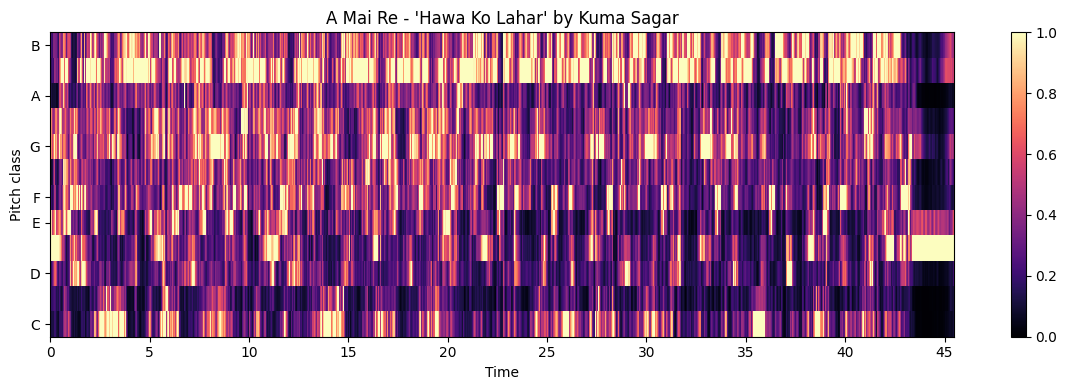

In [62]:
# Now, for the song "A Mai Re - Hawa Ko Lahar," sung by Kuma Sagar.

audio_path = '/content/drive/MyDrive/project25/a_mai_re_kuma_sagar.mp3'
y, sr = librosa.load(audio_path)
y_harmonic, y_percussive = librosa.effects.hpss(y)

song = Tonal_Fragment(y_harmonic, sr)
song.print_key()
print(song.key_return())
song.corr_table()
song.chromagram("A Mai Re - 'Hawa Ko Lahar' by Kuma Sagar")

In [32]:
ipd.Audio(audio_path)